In [4]:
import numpy as np
import pandas as pd
from graphviz import Digraph
import matplotlib.pyplot as plot
from sklearn.tree import export_graphviz
import graphviz
import os

In [6]:
data = pd.read_csv('/Users/saiharshithtanguturi/Desktop/CS6375_Group_7/Code Repo/adm_data.csv')
# data.drop(columns=['Serial No.'], inplace=True)
data.head(5)


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [7]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # for leaf node
        self.value = value

In [8]:
class DecisionTreeRegressor_simple():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["var_red"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur rightvar_red
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_var_red = -float("inf")
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    # update the best split if needed
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        ''' function to compute variance reduction '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        val = np.mean(Y)
        return val
                
#     def print_tree(self, tree=None, indent=" ",feature_names=None):
#         ''' function to print the tree '''
#         if not tree:
#             tree = self.root

#         if tree.value is not None:
#             print(tree.value)

#         else:
#             feature_name = feature_names[tree.feature_index]
#             print(feature_name, "<=", tree.threshold, "?", tree.var_red)
#             print("%sleft----------:" % (indent), end="")
#             self.print_tree(tree.left, indent + indent, feature_names)
#             print("%sright---------:" % (indent), end="")
#             self.print_tree(tree.right, indent + indent, feature_names)



    def export_tree(self, tree=None, feature_names=None,fileName=None):
        ''' function to export the tree to a PNG image '''
        if not tree:
            tree = self.root

        dot = graphviz.Digraph()

        def add_node(node):
            if node.value is not None:
                dot.node(str(id(node)), str(node.value))
            else:
                feature_name = feature_names[node.feature_index]
#                 dot.node(str(id(node)), feature_name + " <= " + str(node.threshold) + " (" + str(node.var_red) + ")")
                dot.node(str(id(node)), f"{feature_name} <= {node.threshold:.2f}")
                add_node(node.left)
                add_node(node.right)
                dot.edge(str(id(node)), str(id(node.left)), label="Yes")
                dot.edge(str(id(node)), str(id(node.right)), label="No")

        add_node(tree)
        dot.render(fileName, format="png")


    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        ''' function to predict new dataset '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        ''' function to predict a single data point '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
   
 
   



----------------MAX_DEPTH for - 3 ----------------------


Fold 0 MSE 0.005355736368600944
Fold 1 MSE 0.005185535885893481
Fold 2 MSE 0.007287747758336227
Fold 3 MSE 0.007902748503644159
Fold 4 MSE 0.005213840690380648
Overall MSE error average for k-fold 0.006189121841371091
Overall Standard Deviation for k-fold 0.0013034938322460615


----------------MAX_DEPTH for - 4 ----------------------


Fold 0 MSE 0.005093987486708243
Fold 1 MSE 0.00584962366567458
Fold 2 MSE 0.009082026496642448
Fold 3 MSE 0.0045323480073016734
Fold 4 MSE 0.005313379783639852
Overall MSE error average for k-fold 0.012163394929364451
Overall Standard Deviation for k-fold 0.0014860942102346063


----------------MAX_DEPTH for - 5 ----------------------


Fold 0 MSE 0.006051180570498349
Fold 1 MSE 0.006028190681340697
Fold 2 MSE 0.005372940967779438
Fold 3 MSE 0.006815107053290271
Fold 4 MSE 0.007520022366855755
Overall MSE error average for k-fold 0.018520883257317353
Overall Standard Deviation for k-fold 0.001

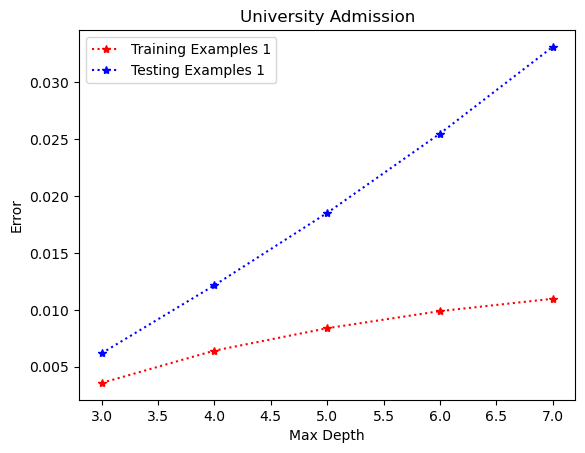

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import statistics
import graphviz
import numpy as np
import matplotlib.pyplot as plot
from sklearn import tree
import statistics
# Define the number of folds
k = 5

# Initialize the KFold object
kf = KFold(n_splits=k, shuffle=True)

# Initialize a list to store the performance metric for each fold
mse_scores = []
mse_scorest = []
mse_list=[]
mse_list_t=[]
mse_score_sk=[]
mse_list_sk=[]

count = 0
max_d=[3, 4, 5, 6, 7]
# Loop over each value of max_dep
for max_dep in [3, 4, 5, 6, 7]:
    # Initialize a list to store the graph objects for each fold
    print("\n")
    print('----------------MAX_DEPTH for -' ,max_dep,'----------------------')
    print("\n")
    # Loop over each fold
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        # Get the training and validation data for this fold
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        
        # create a variable with changing index
        fileName = f"fold_{i}_max_depth_{max_dep}"

        # Split the data into features and target
        X_train = train_data.iloc[:, :-1].values
        Y_train = train_data.iloc[:, -1].values.reshape(-1,1)
        X_test = test_data.iloc[:, :-1].values
        Y_test = test_data.iloc[:, -1].values.reshape(-1,1)
        # Train a decision tree regressor on the training data
        regressor = DecisionTreeRegressor_simple(min_samples_split=3, max_depth=max_dep)
        regressor.fit(X_train,Y_train)
        regressor.export_tree(feature_names=train_data.columns[:-1],fileName=fileName)
        y_pred_t = regressor.predict(X_train)
        mse_t = mean_squared_error(Y_train, y_pred_t)
        mse_scorest.append(mse_t)
        # Compute the performance metric for this fold
        y_pred = regressor.predict(X_test)
        mse = mean_squared_error(Y_test, y_pred)
        print("Fold",i,'MSE', mse)
        mse_scores.append(mse)  
        
    mse_st=sum(mse_scorest)/5
    mse_list_t.append(mse_st)
    mse_s=sum(mse_scores)/5
    print('Overall MSE error average for k-fold',mse_s)
    print('Overall Standard Deviation for k-fold',statistics.stdev(mse_scores))
    mse_list.append(mse_s)
    

        
    
plot.title("University Admission")
plot.xlabel("Max Depth")
plot.ylabel("Error")
plot.plot(max_d ,mse_list_t, '*:r', label='Training Examples 1')
plot.plot(max_d ,mse_list, '*:b', label='Testing Examples 1')
plot.legend()
plot.show()



    
    
        
        
    



----------------MAX_DEPTH for - 3 ----------------------


Fold 0 MSE 0.00969625
Fold 1 MSE 0.007542500000000001
Fold 2 MSE 0.009972499999999999
Fold 3 MSE 0.006716249999999998
Fold 4 MSE 0.00993875
Overall MSE error average for k-fold 0.00877325
Overall Standard Deviation for k-fold 0.0015325236029993144


----------------MAX_DEPTH for - 4 ----------------------


Fold 0 MSE 0.0077824999999999995
Fold 1 MSE 0.00952375
Fold 2 MSE 0.008375000000000002
Fold 3 MSE 0.0092375
Fold 4 MSE 0.006465000000000001
Overall MSE error average for k-fold 0.01705
Overall Standard Deviation for k-fold 0.001334383700856358


----------------MAX_DEPTH for - 5 ----------------------


Fold 0 MSE 0.0097075
Fold 1 MSE 0.00852
Fold 2 MSE 0.011300000000000001
Fold 3 MSE 0.007025000000000001
Fold 4 MSE 0.00729375
Overall MSE error average for k-fold 0.02581925
Overall Standard Deviation for k-fold 0.0014340432713717765


----------------MAX_DEPTH for - 6 ----------------------


Fold 0 MSE 0.01292249999999999

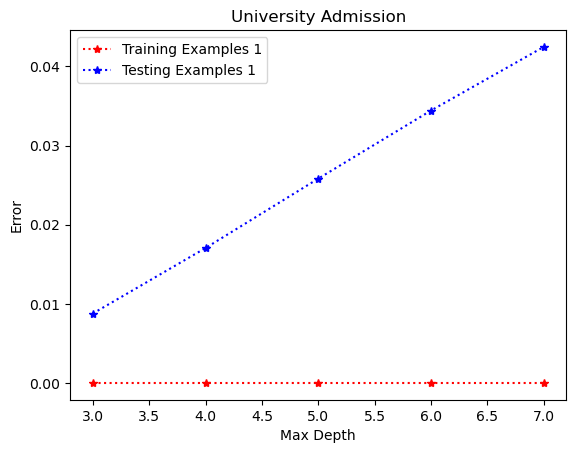

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import statistics
import graphviz
import numpy as np
import matplotlib.pyplot as plot
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import statistics
# Define the number of folds
k = 5

# Initialize the KFold object
kf = KFold(n_splits=k, shuffle=True)

# Initialize a list to store the performance metric for each fold
mse_scores = []
mse_scorest = []
mse_list=[]
mse_list_t=[]
mse_score_sk=[]
mse_list_sk=[]

count = 0
max_d=[3, 4, 5, 6, 7]
# Loop over each value of max_dep
for max_dep in [3, 4, 5, 6, 7]:
    # Initialize a list to store the graph objects for each fold
    print("\n")
    print('----------------MAX_DEPTH for -' ,max_dep,'----------------------')
    print("\n")
    # Loop over each fold
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        # Get the training and validation data for this fold
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        
        # create a variable with changing index
        fileName = f"fold_{i}_max_depth_{max_dep}"

        # Split the data into features and target
        X_train = train_data.iloc[:, :-1].values
        Y_train = train_data.iloc[:, -1].values.reshape(-1,1)
        X_test = test_data.iloc[:, :-1].values
        Y_test = test_data.iloc[:, -1].values.reshape(-1,1)
        # Train a decision tree regressor on the training data
        dt = DecisionTreeRegressor(random_state=42)
        # Fit the model on the training data
        dt.fit(X_train, Y_train)
        y_pred_t = dt.predict(X_train)
        mse_t = mean_squared_error(Y_train, y_pred_t)
        mse_scorest.append(mse_t)
        # Compute the performance metric for this fold
        y_pred = dt.predict(X_test)
        mse = mean_squared_error(Y_test, y_pred)
        print("Fold",i,'MSE', mse)
        mse_scores.append(mse)  
        
    mse_st=sum(mse_scorest)/5
    mse_list_t.append(mse_st)
    mse_s=sum(mse_scores)/5
    print('Overall MSE error average for k-fold',mse_s)
    print('Overall Standard Deviation for k-fold',statistics.stdev(mse_scores))
    mse_list.append(mse_s)
    


plot.title("University Admission")
plot.xlabel("Max Depth")
plot.ylabel("Error")
plot.plot(max_d ,mse_list_t, '*:r', label='Training Examples 1')
plot.plot(max_d ,mse_list, '*:b', label='Testing Examples 1')
plot.legend()
plot.show()

    
    
        
        
    